### This file is a work in progress

Please see README.MD for updates.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import shap
import xgboost as xgb

from scipy.stats.stats import pearsonr
from util import MatchesData, DuelsData, plotCalibrationCurve, PredATKDEF, getPlayersdf

Code for utility functions (where most of the model's training and testing occurs) will be released separately over the next coming weeks. 

In [2]:
MD = MatchesData("DATA_XY/VCT3NAmatches.csv", "DATA_XY/playerId.csv", "JSON_SCRAPED")
NewData = DuelsData("DATA_XY/VCT3_NA_All.csv")
features = [
    "px",
    "py",
    "ex",
    "ey",
    "roundTime",
    "isPlanted",
    "spikeBPS",
    "pgun",
    "parmor",
    "egun",
    "atkAlive",
    "defAlive",
    "atkNumGuns",
    "defNumGuns",
    "roundHalf",
    "atkWonLast",
    "defWonLast",
    "MapInt",
]

Fitting the model

In [3]:
optimal_params = {
    "colsample_bytree": 0.7581049567418119,
    "learning_rate": 0.0461352829775619,
    "max_depth": 6,
    "min_child_weight": 3,
    "n_estimators": 144,
    "subsample": 0.4196367095952316,
}
preds = PredATKDEF(
    NewData,
    MD.train_valid_matches,
    MD.test_matches,
    features,
    xgb.XGBClassifier(
        use_label_encoder=False, verbosity=0, random_state=42, **optimal_params,
    ),
    MD.df_ids,
)

y_true, y_pred, dfexp = preds.fitpred_ATKDEF()

Calibration curve

Brier Score Loss:  0.22850640684121784


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


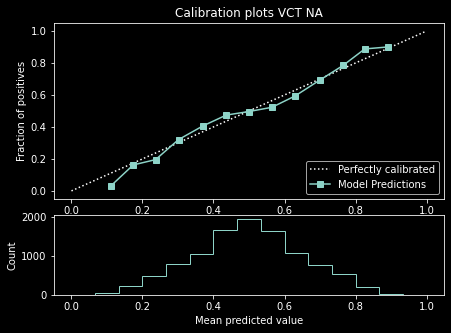

In [4]:
plt.style.use("dark_background")
fig = plotCalibrationCurve(y_true=y_true, y_pred=y_pred, n_bins=15)
fig.show()

Player evaluation, raw data and plot

In [5]:
dfplayers = getPlayersdf(dfexp)
dfplayers.sort_values(by="wins_above_expected", ascending=False).head(15)

Total Players: 39


,,team_name,tot_duels,tot_rounds,tot_games,exp_kills,tot_kills,wins_above_expected,med_diff,kills,KDA
playerId,Ign,,,,,,,,,,
1994,supamen,Rise,364,233,12,175.891937,196.0,0.055242,0.222620,196.0,1.166667
1522,TiGG,Luminosity Gaming,151,94,5,76.601692,82.0,0.035750,0.228927,82.0,1.188406
3074,aproto,Luminosity Gaming,147,88,5,71.071236,76.0,0.033529,0.197590,76.0,1.070423
763,Asuna,100 Thieves,407,245,12,209.715652,223.0,0.032640,0.241127,223.0,1.211957
1961,xeta,Cloud9 Blue,387,269,16,196.735291,208.0,0.029108,0.227344,208.0,1.162011
10253,Ethan,100 Thieves,371,236,12,188.909149,198.0,0.024504,0.215796,198.0,1.144509
355,Hiko,100 Thieves,297,211,12,144.286758,151.0,0.022603,0.208002,151.0,1.034247
269,Derrek,Rise,321,219,12,152.794785,160.0,0.022446,-0.170215,160.0,0.993789
4639,vanity,Cloud9 Blue,421,281,16,210.176285,217.0,0.016208,0.173926,217.0,1.063725


In [6]:
fig = px.scatter(
    dfplayers.reset_index(),
    x="KDA",
    y="wins_above_expected",
    color="team_name",
    text="Ign",
    hover_data=["Ign", "team_name"],
    template="plotly_dark",
)

fig.update_traces(textposition="bottom right", textfont={"size": 9})

fig.update_layout(font_family="Courier New",)

Finding good player on ecos, nitr0's plot

Total Players: 27


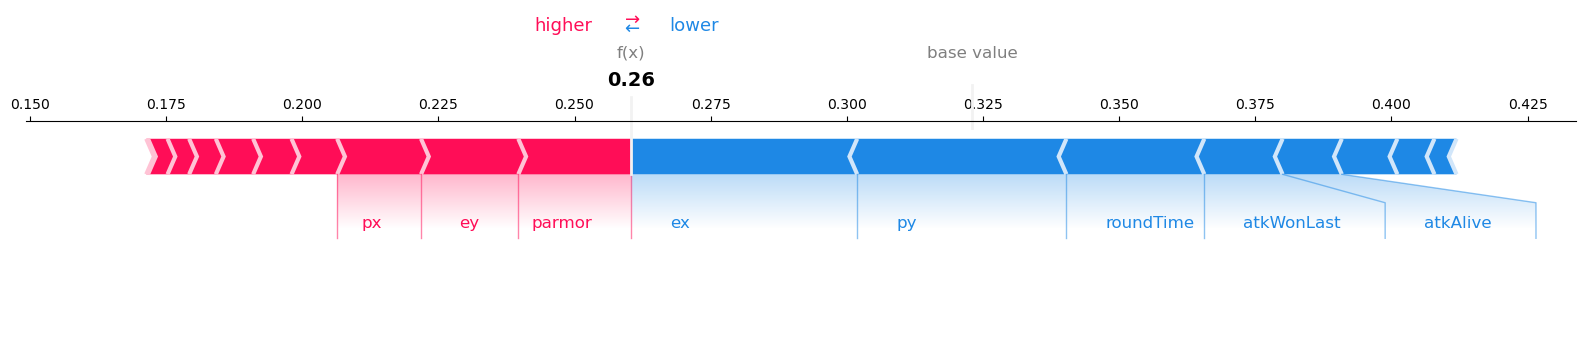

In [11]:
plt.style.use("default")
dfecos = dfexp[
    (dfexp["pgun"] < 1600)
    & (dfexp["pgun"] > 0)
    & (dfexp["egun"] > 1600)
    & (dfexp["egun"] < 2902)
]

dfplayers_ecos = getPlayersdf(dfecos)
dfplayers_ecos.sort_values(by="wins_above_expected", ascending=False).head(15)

#%%
find_match = dfecos[dfecos["Ign"] == "nitr0"].sort_values("DIFF")
df_shap = find_match[preds.features]
explainer = shap.TreeExplainer(
    preds.modelDEF, data=shap.sample(df_shap, 100), model_output="probability"
)
shap_values = explainer.shap_values(
    df_shap
)  # [1]; # index 1 pulls the P(y=1) SHAP values for RandomForest.

id = 24  ##Used in paper https://youtu.be/3QfaONI9gMo?t=8292
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[id],
    feature_names=preds.XDEF.columns,
    matplotlib=True,
)

Total Players: 15


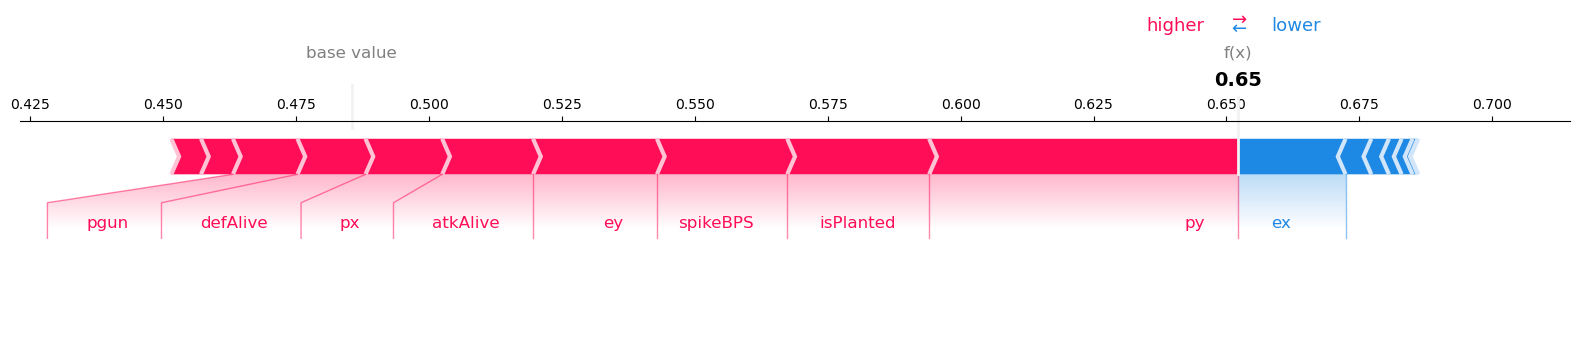

In [12]:
df_agOP = dfexp[(dfexp["egun"] > 4500)]
dfplayers_agOP = getPlayersdf(df_agOP)
dfplayers_agOP.sort_values(by="wins_above_expected", ascending=False).head(15)

find_match2 = df_agOP[df_agOP["Ign"] == "Hiko"].sort_values("DIFF") #%%
df_shap = find_match2[preds.features]
explainer = shap.TreeExplainer(
    preds.modelATK, data=shap.sample(df_shap, 100), model_output="probability"
)
shap_values = explainer.shap_values(df_shap)

id = 6  ##Used in paper
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[id],
    feature_names=preds.XATK.columns,
    matplotlib=True,
)

Correlation calculations

In [13]:
preds2 = PredATKDEF(
    NewData,
    MD.train_matches,
    MD.valid_test_matches,
    features,
    xgb.XGBClassifier(
        use_label_encoder=False, verbosity=0, random_state=42, **optimal_params,
    ),
    MD.df_ids,
)
y_true, y_pred, dfexp = preds2.fitpred_ATKDEF()

#%%

dfexp_valid = dfexp[dfexp["matchId"].isin(MD.valid_matches)]
dfexp_test = dfexp[dfexp["matchId"].isin(MD.test_matches)]

common_players = set(dfexp_valid["playerId"].values).intersection(
    set(dfexp_test["playerId"].values)
)

dfpl_valid = getPlayersdf(dfexp_valid)
dfpl_test = getPlayersdf(dfexp_test)

#%%Get scores from ADR
all_scores = pd.read_csv("DATA_XY/VCT3_NA_Scores.csv")
valid_scores = all_scores[all_scores["MatchID"].isin(MD.valid_matches)]
test_scores = all_scores[all_scores["MatchID"].isin(MD.test_matches)]

score_cols = ["KDA", "wins_above_expected"]
dfcommon = dfpl_valid[score_cols].merge(
    dfpl_test[score_cols], how="inner", left_index=True, right_index=True
)
dfcommon = dfcommon.droplevel("Ign")
dfcommon["validADR"] = valid_scores.groupby("playerId")["score"].mean()
dfcommon["testADR"] = test_scores.groupby("playerId")["score"].mean()

Total Players: 37
Total Players: 39


Correlation between tournaments

In [14]:
pearsonr(dfcommon["wins_above_expected_x"], dfcommon["wins_above_expected_y"])


(0.21542520912734367, 0.3235527759536678)

In [15]:
pearsonr(dfcommon["KDA_x"], dfcommon["KDA_y"])


(0.17223543597026497, 0.43195651244603356)

In [16]:
pearsonr(dfcommon["validADR"], dfcommon["testADR"])

(0.18535517408896293, 0.3971441787574859)